# Goal: High Test Accuracy with RoBERTa and LoRa

In this project, we use a pretrained specific version of BERT known as RoBERTa. The only changes we can make are to the low-rank adapation (LoRA) portion. Instead of adjusting each of the weights one by one for a model, there is a weight matrix that is changed by a low-rank matrix. For the low-rank matric, the characteristics such as its strength can be tuned.

This submission finetunes the LoRA portion and prints out a CSV for the Kaggle competition.

# Registering Input in Kaggle
To test our model with the unlabelled data, it needs to be inputted first. This is done by pressing "File", "Add input" and then adding the deep learning competition that was joined previously. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl


# Starter Notebook
The following code is the starter notebook. It includes the RoBERTa pretrained model. This part of the code must remain unchanged for the competition. Some extra modules are needed for this project, such as nvidia-ml-py3 which are installed using pip.

# Import Libraries and Cuda
The following libraries are needed to run the model and use LoRA. We also must use cuda for the GPU. If we were to use CPU, training could take way longer! (It already is super long with the GPU!!)

In [2]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle
#os.environ['WANDB_DISABLED'] = 'true'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2025-04-18 20:16:26.221125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745007386.396427      73 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745007386.448777      73 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


## Load Tokenizer and Preprocess Data
We cannot just pass strings to the model as computers cannot process them. They can only understand numbers. Therefore, a tokenizer is needed to convert words to numbers. This stage is known as preprocessing the data. We are loading the train dataset from the AG_News dataset as that is all we need to train our model. We will test it with the unlabelled data provided by the competition.

The starter notebook had padding=true which is for dynamic padding. However, I ran into several issues with log information not having init initialized. After adding the os.environ line above, another error was thrown always at batch 101. It was that the data not matching tensor sizes. Therefore, I set padding to max length of 128. The model started training.

In [3]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding="max_length", max_length=128)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Essentially, there are four types of news articies which are the following categories. This model classifies an inputted news article and outputs its category.

In [4]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


In [5]:
id2label


{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face. After downloading the model, we can add LoRA.

In [6]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    num_labels=4)

model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

# Split the Datasets
Using the train_test_split() function, I split the AGnews data set for the model to train.

In [7]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning. After tuning Lora, the lora_alpha would adjust the effect of the weight matrix. The rank would significantly change the parameters. After trying r = 5, r = 8 and so forth, I kept r = 4 and alpha = 8. It is has 200,000 less parameters than the limit. BUT! for a simple dataset like AGNews, having a less complex model that can observe patterns can be just as beneficial!!

In [8]:
# PEFT Config
peft_config = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.1,
    bias = 'none',
    target_modules = ['query', 'key', 'value'],
    task_type="SEQ_CLS"
)

In [9]:
model = get_peft_model(model, peft_config)
model.to(device)
model.print_trainable_parameters()

trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495


In [10]:
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.key.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.key.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.key.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.

In [11]:
print('PEFT Model')
model.print_trainable_parameters()

PEFT Model
trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495


## Training Setup

compute_metrics() was adjusted so that each accuracy can be added to a list. That list will then have its values plotted! While there are a small amount of epochs, I use steps that displays stats multiple times during an epoch. 

In [12]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracies = [];
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    accuracies.append(accuracy)
    return {
        'accuracy': accuracy
    }

In [13]:
# Setup Training args
output_dir = "./results"
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="steps",
    save_strategy="no",
    logging_steps=400,
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    #data_collator=data_collator, 
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


### Start Training
The .train() function from Hugging Phase includes this graph to show the accuracy, validation loss, and training loss! It also saves all the values to trainer.state.log_history() to be graphed. The accuracy was also climbing to as high as 94% which is great!

In [14]:
result = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
400,0.474000,0.334018,0.903125
800,0.291700,0.305480,0.917188
1200,0.274100,0.288880,0.912500
1600,0.278300,0.279128,0.906250
2000,0.251600,0.272870,0.910937
2400,0.242900,0.291991,0.904687
2800,0.227600,0.241737,0.915625
3200,0.227600,0.252701,0.926562
3600,0.212100,0.240749,0.921875
4000,0.209900,0.222834,0.929688


# Plotting Progress

Using matplotlib, the validation losses, training losses, and the accuracies are plotted to see the model's progress over time!

In [15]:
import matplotlib.pyplot as plt

In [16]:
val_losses = []
for log in trainer.state.log_history:
    if "eval_loss" in log:
        val_losses.append(log['eval_loss'])
val_losses

[0.3340177834033966,
 0.3054799437522888,
 0.2888796925544739,
 0.2791284918785095,
 0.2728700339794159,
 0.29199060797691345,
 0.24173741042613983,
 0.2527013421058655,
 0.24074947834014893,
 0.2228340357542038,
 0.22487100958824158,
 0.23916807770729065,
 0.22423453629016876,
 0.2078561782836914,
 0.21504473686218262,
 0.22164949774742126,
 0.21021881699562073,
 0.21864037215709686,
 0.2189193069934845,
 0.20449945330619812,
 0.20584221184253693,
 0.217828631401062,
 0.20961932837963104,
 0.2195897400379181,
 0.2315749228000641,
 0.21301989257335663,
 0.20771968364715576,
 0.20323458313941956,
 0.20999208092689514,
 0.1994340419769287,
 0.2016528844833374,
 0.2041914463043213,
 0.210697203874588,
 0.21179182827472687,
 0.2027306854724884,
 0.2082441747188568,
 0.20542049407958984,
 0.20128217339515686,
 0.20126362144947052,
 0.20772914588451385,
 0.19726215302944183,
 0.21199946105480194,
 0.20287498831748962,
 0.208661288022995,
 0.20584669709205627,
 0.20210620760917664,
 0.2009591

In [17]:
train_losses = []
for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
train_losses

[0.474,
 0.2917,
 0.2741,
 0.2783,
 0.2516,
 0.2429,
 0.2276,
 0.2276,
 0.2121,
 0.2099,
 0.2218,
 0.2168,
 0.2143,
 0.1855,
 0.2134,
 0.196,
 0.2152,
 0.1942,
 0.2078,
 0.1966,
 0.1937,
 0.1892,
 0.1952,
 0.1871,
 0.1773,
 0.1853,
 0.196,
 0.18,
 0.1823,
 0.1772,
 0.1813,
 0.1789,
 0.1793,
 0.1666,
 0.182,
 0.1752,
 0.1911,
 0.1803,
 0.1698,
 0.1647,
 0.1688,
 0.1559,
 0.1732,
 0.1661,
 0.1734,
 0.1676,
 0.1677,
 0.1637,
 0.1654,
 0.1673,
 0.1548,
 0.1719,
 0.1732,
 0.1462,
 0.1694]

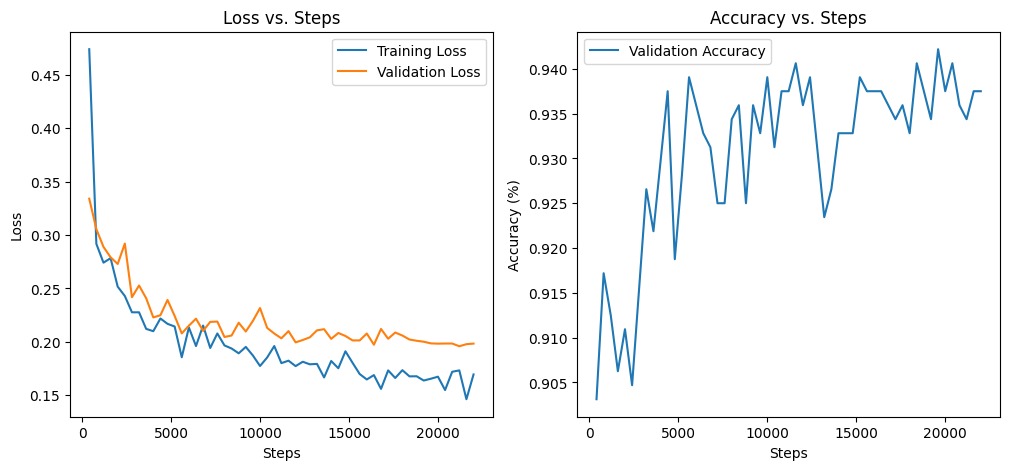

In [18]:
plt.figure(figsize=(12, 5))
epochs = np.arange(400, 22380, 400)
epochs = epochs[:len(train_losses)]
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss vs. Steps")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label="Validation Accuracy")
#plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Steps")
plt.legend()

plt.show()

## Evaluate Finetuned Model
Time to evaluate our model. We use the eval_dataset used earlier for validating our model

### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [19]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [20]:
classify( model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [21]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==

In [22]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [23]:
# Check evaluation accuracy
validation_acc = evaluate_model(model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:02<00:00, 28.16it/s]

Evaluation Metric: {'accuracy': 0.940625}


# Time to Test our Model with a test dataset from AGNews

To find the test accuracy, the test dataset from agnews is retrieved and tokenized. The evaluate_model() is used with labelling equal to true to return the test accuracy. The results are slightly higher than the evaluation accuracy demonstrating no overfitting!

In [24]:
dataset_test = load_dataset('ag_news', split='test')

tokenized_test = dataset_test.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_test = tokenized_test.rename_column("label", "labels")
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [25]:
test_acc = evaluate_model(model, tokenized_test, True, 8, data_collator)

100%|██████████| 950/950 [00:33<00:00, 28.62it/s]


Evaluation Metric: {'accuracy': 0.9439473684210526}


FINAL TEST ACCURACY: 94.4%. Higher than evaluation accuracy!

### Run Inference on unlabelled dataset
The unlabelled dataset is retrieved from the competition and inputted to the evaluate_model() function with labelling set to false. This is because the dataset does not have any labels to check the predictions. The predictions are stored to a csv for submission.

In [26]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [27]:
# Run inference and save predictions
preds = evaluate_model(model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:34<00:00, 28.94it/s]

Inference complete. Predictions saved to inference_output.csv
